In [37]:
%matplotlib inline
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
import matplotlib.image as mpimg
import random

In [38]:
def load_image(path, gt=False):
    if gt:
        image = Image.open(path).convert('L')
    else:
        image = Image.open(path).convert('RGB')
        
    transform = torchvision.transforms.ToTensor()

    image = transform(image)

    if gt:
        image = image
        image = compress_image(image)
        
    return image

def compress_image(img, patch_size=16, thres=0.25):
    w = img.shape[1]
    h = img.shape[2]
    c = img.shape[0]

    compressed = torch.zeros(c, int(w / patch_size), int(h / patch_size))
    
    for i in range(0, compressed.shape[1]):
        for j in range(0, compressed.shape[2]):
            patch = img[:, patch_size * i : patch_size * (i + 1), patch_size * j : patch_size * (j + 1)]
            patch_mean = patch.mean(dim=(1, 2))
            compressed[:, i, j] = (patch_mean > thres)

    return compressed 
    

def view_image(img):
    img = torchvision.transforms.functional.to_pil_image(img)
    img = np.array(img)

    plt.imshow(img, cmap='Greys_r')
    plt.show()

In [39]:
root_dir = './training/'
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth/"
files = os.listdir(image_dir)

train_files = random.sample(files, 80)
val_files = list(set(files) - set(train_files))

print("Loading training images")
train_imgs = [load_image(image_dir + f) for f in train_files]
train_gt_imgs = [load_image(gt_dir + f, gt=True) for f in train_files]

print("Loading validation images")
val_imgs = [load_image(image_dir + f) for f in val_files]
val_gt_imgs = [load_image(gt_dir + f, gt=True) for f in val_files]


Loading training images
Loading validation images


In [40]:
from torch.utils.data import DataLoader, Dataset
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_paths, gt_paths, transform=None):
        self.image_paths = image_paths
        self.gt_paths = gt_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        gt_image = load_image(self.gt_paths[idx], gt=True)
        if self.transform:
            image = self.transform(image)
            gt_image = self.transform(gt_image)
        return image, gt_image
    
def create_dataloaders(batch_size=4):
    root_dir = './training/'
    image_dir = root_dir + "images/"
    gt_dir = root_dir + "groundtruth/"

    files = os.listdir(image_dir)
    train_files = random.sample(files, 80)
    val_files = list(set(files) - set(train_files))

    train_image_paths = [image_dir + f for f in train_files]
    train_gt_paths = [gt_dir + f for f in train_files]
    val_image_paths = [image_dir + f for f in val_files]
    val_gt_paths = [gt_dir + f for f in val_files]

    train_dataset = RoadSegmentationDataset(train_image_paths, train_gt_paths)
    val_dataset = RoadSegmentationDataset(val_image_paths, val_gt_paths)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [41]:
class DoubleConv_1(torch.nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class DoubleConv_2(torch.nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)
    

class Down(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv_2(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class Jump(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv_1(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = torch.nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv_2(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class Road_Seg_Model(torch.nn.Module):
    def __init__(self, n_channels):
        super(Road_Seg_Model, self).__init__()
        self.n_channels = n_channels

        self.inc = (DoubleConv_1(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.jump = (Jump(128, 256))
        self.down2 = (Down(256, 512))
        self.up = (Up(512, 256))
        self.outc = (OutConv(256, 1))


    def forward(self, x):
        # print(f"x:{x.shape}")
        x1 = self.inc(x)
        # print(f"x1:{x1.shape}")
        x2 = self.down1(x1)
        # print(f"x2:{x2.shape}")
        x3 = self.jump(x2)
        # print(f"x3:{x3.shape}")
        x4 = self.down2(x3)
        # print(f"x4:{x4.shape}")
        x = self.up(x4, x3)
        # print(f"x5:{x.shape}")
        logits = self.outc(x)
        # print(f"x6:{x.shape}")
        return logits



In [42]:
def train(model, criterion, dataset_train, dataset_test, optimizer, num_epochs, device):
    
    

    print("Starting training")
    for epoch in range(num_epochs):

        model.train()
        for batch_x, batch_y in dataset_train:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in dataset_test:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()

        print(f'{epoch+1}/{num_epochs}: Validation Loss = {val_loss/len(dataset_test):.4f}')



In [43]:
num_epochs = 20
learning_rate = 1e-6
weight_decay = 1e-8
momentum = 0.999
batch_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = create_dataloaders(batch_size)

criterion = (
    torch.nn.BCEWithLogitsLoss()
)
 
model_seg = Road_Seg_Model(n_channels=3).to(device)

optimizer = torch.optim.RMSprop(model_seg.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
train(model_seg, criterion, train_loader, val_loader, optimizer, num_epochs, device)


Starting training
1/20: Validation Loss = 0.6600
2/20: Validation Loss = 0.6076
3/20: Validation Loss = 0.5713
4/20: Validation Loss = 0.5713
5/20: Validation Loss = 1.8086
6/20: Validation Loss = 1.0779
7/20: Validation Loss = 0.5444
8/20: Validation Loss = 0.6492
9/20: Validation Loss = 0.6140
10/20: Validation Loss = 0.6108
11/20: Validation Loss = 0.5461
12/20: Validation Loss = 0.3796
13/20: Validation Loss = 0.3452
14/20: Validation Loss = 0.3612
15/20: Validation Loss = 0.4136
16/20: Validation Loss = 0.3913
17/20: Validation Loss = 0.3454
18/20: Validation Loss = 0.3707
19/20: Validation Loss = 0.3958
20/20: Validation Loss = 0.3628


In [44]:
val_imgs[0].shape

torch.Size([3, 400, 400])

In [45]:
model_seg.to('cuda')
model_seg.eval()
tensor = val_imgs[0].unsqueeze(0).to('cuda')
pred = model_seg(tensor)


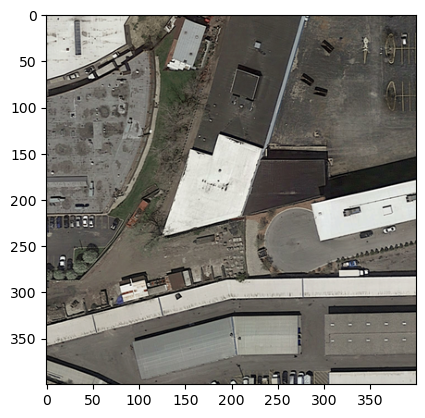

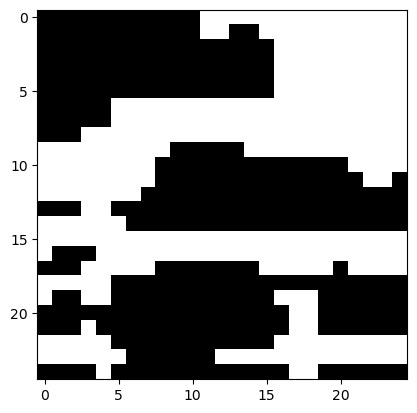

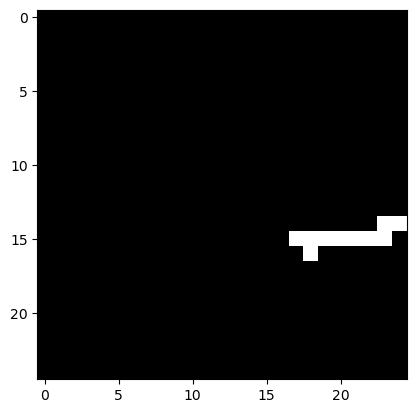

In [46]:
pred_img = (pred.squeeze(0) > 0.25).float()
view_image(val_imgs[0])
view_image(pred_img)
view_image(val_gt_imgs[0])

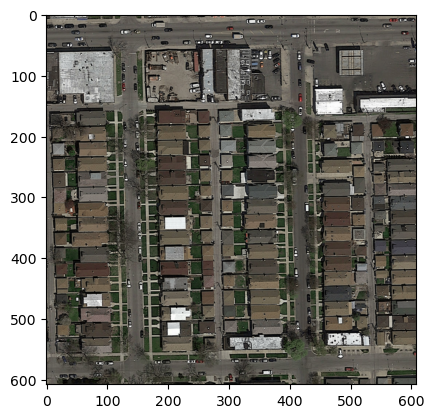

In [47]:
img = load_image('./test_set_images/test_1/test_1.png')
view_image(img)

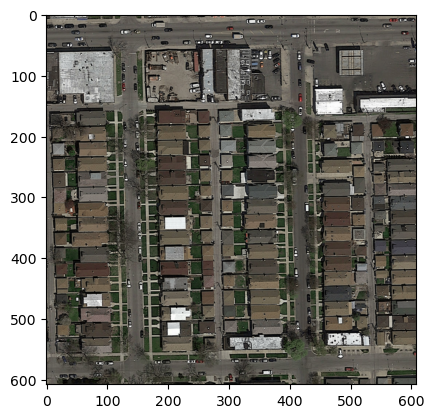

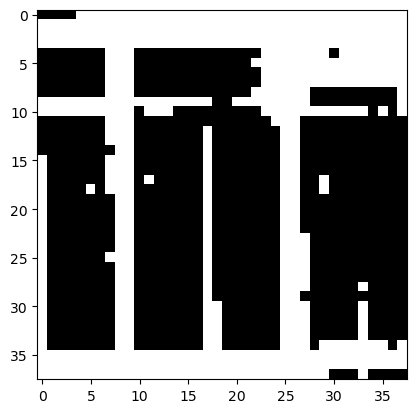

In [48]:
model_seg.to('cuda')
model_seg.eval()
tensor = img.unsqueeze(0).to('cuda')
pred = model_seg(tensor)

pred_img = (pred.squeeze(0) > 0.25).float()
view_image(img)
view_image(pred_img)
